In [52]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def melt_file(file,sheetname):

    '''
    Def:  unpivots the file on days as rows, removes international flights,
        removes rows without scheduled flights and removes unnecessary columns,
        datetime columns are added for departure, arrival, and release times,
        hour columns for each event are calculated from those columns,
        flight ID is added as a concatenation of Departure Datetime, Flight Number,
        Origin, and Destination
    Inputs:
        file: raw schedule Excel file
        sheetname: sheetname of domestic scheuld file
    Return: unpivoted dataframe with time formats and flight IDs
    '''

    # create dataframes from Excel
    df = pd.read_excel(file, sheetname) #CHANGE FILE AND SHEET NAMES

    # create airport list
    aiport_list = ['ABE', 'ABQ', 'AGS', 'ALB', 'ATL', 'ATW', 'AUS', 'AVL', 'AVP', 'BDL', 'BGR', 'BHM', 'BIL', 'BIS', 'BNA', 'BOI', 'BOS', 'BTR', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN', 'CAE', 'CAK', 'CHA', 'CHO', 'CHS', 'CID', 'CLE', 'CLT', 'CMH', 'COS', 'CRW', 'CVG', 'DAB', 'DAL', 'DAY', 'DCA', 'DEN', 'DFW', 'DSM', 'DTW', 'ECP', 'EGE', 'ELP', 'EVV', 'EWR', 'EYW', 'FAR', 'FAY', 'FCA', 'FLL', 'FNT', 'FSD', 'GEG', 'GNV', 'GPT', 'GRB', 'GRR', 'GSO', 'GSP', 'GTF', 'HDN', 'HOU', 'HPN', 'HSV', 'IAD', 'IAH', 'ICT', 'ILM', 'IND', 'JAC', 'JAN', 'JAX', 'JFK', 'LAS', 'LAX', 'LEX', 'LFT', 'LGA', 'LGB', 'LIT', 'MCI', 'MCO', 'MDT', 'MDW', 'MEM', 'MHT', 'MIA', 'MKE', 'MLB', 'MOB', 'MSN', 'MSO', 'MSP', 'MSY', 'MTJ', 'MYR', 'OAK', 'OKC', 'OMA', 'ONT', 'ORD', 'ORF', 'PBI', 'PDX', 'PHF', 'PHL', 'PHX', 'PIT', 'PNS', 'PSC', 'PSP', 'PVD', 'PWM', 'RAP', 'RDU', 'RIC', 'RNO', 'ROA', 'ROC', 'RSW', 'SAN', 'SAT', 'SAV', 'SBN', 'SDF', 'SEA', 'SFO', 'SJC', 'SLC', 'SMF', 'SNA', 'SRQ', 'STL', 'SYR', 'TLH', 'TPA', 'TRI', 'TUL', 'TUS', 'TVC', 'TYS', 'VPS', 'XNA', 'YEG', 'YUL', 'YVR', 'YWG', 'YXE', 'YYC', 'YYZ']
    df = df[df['Org'].isin(aiport_list)]
    df = df[df['Dst'].isin(aiport_list)]

    # melts dataframe
    melt = pd.melt(df, id_vars=['Flt','Org','Dst','Eqt','Dptr','Arvl','BLK MINS','MILES','Desk']
        ,value_vars=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
        ,var_name = 'Day'
        ,value_name = 'Schd')

    # drop not scheduled flights N/A
    melt = melt.dropna(subset=['Schd'])

    # set Year, Month and Date
    melt['Month'] =  month
    melt['Year'] =  year
    melt['Date'] = pd.to_datetime(melt[['Year', 'Month', 'Day']])

    # make Departure, Arrival, and Release time columns
    melt['Dept_Time'] = pd.to_datetime(melt['Year'].astype(str) + '/' + melt['Month'].astype(str) + '/' + melt['Day'].astype(str) + ' ' +melt['Dptr'].astype(str),utc=True)
    melt['Arr_Time'] = pd.to_datetime(melt['Year'].astype(str) + '/' + melt['Month'].astype(str) + '/' + melt['Day'].astype(str) + ' ' +melt['Arvl'].astype(str),utc=True)
    melt['Rls_Time'] = melt['Dept_Time'] + pd.Timedelta(minutes=-90)

    melt = melt.drop(columns=['BLK MINS', 'Dptr','Arvl','Year', 'Month','Schd'])

    # make Hour Columns for each time
    melt['Rls_HR'] = melt['Rls_Time'].dt.hour
    melt['Dept_HR'] = melt['Dept_Time'].dt.hour
    melt['Arr_HR'] = melt['Arr_Time'].dt.hour

    melt['FltID'] = melt['Dept_Time'].astype(str) + melt['Flt'].astype(str) + melt['Org'].astype(str) + melt['Dst'].astype(str)
    melt['Desk'] = melt['Desk'].astype(str)
    
    return melt

def handoff(file,sheet):
    
    '''
    Def:  takes in and reads shift file used for handoffs
    Inputs:
        file: raw schedule Excel file
        sheet: sheet name of handoff file
    Return: dataframe with desks, shift start time, shift end time, recieve from desk, and transfer to desk
    '''
    #Read all three columns of shift sheet
    df = pd.read_excel(file, sheet_name=sheet, names = ['DESK', 'START', 'END', 'Receive From', 'Xfr To'],index_col=None, usecols = "A:E", nrows= 70,dtype=str) 
    df2 = pd.read_excel(file, sheet_name=sheet, names = ['DESK', 'START', 'END', 'Receive From', 'Xfr To'],index_col=None, usecols = "G:K", nrows=15,dtype=str) 
    midnight_desks = pd.read_excel(file, sheet_name=sheet, names = ['DESK', 'START', 'END', 'Xfr To','Receive From'], index_col=None, usecols = "G:K", skiprows=18, nrows=8,dtype=str) 
    
    #Append AM and PM desks together
    df = df.append(df2).dropna()
    df['DESK'] = df['DESK'].str.slice(stop=3)
    for i in df['DESK']:
        if i[0] == 'A':
            i = i[1:]
            
    #Switch Xfr To and Receive From columns to match AM/PM Desks
    midnight_desks = midnight_desks.filter(['DESK', 'START', 'END', 'Receive From', 'Xfr To'])
    
    #Append Midnight desks to AM/PM
    df = df.append(midnight_desks)
    
    #Change start and end times to datetime times
    df['START'] = pd.to_datetime(df['START'].astype(str))
    df['START'] = (df['START'] + pd.Timedelta(hours=gmt_convert)).dt.time
    df['END'] = pd.to_datetime(df['END'].astype(str))
    df['END'] = (df['END'] + pd.Timedelta(hours=gmt_convert)).dt.time
    return df

def desk_filter(df, date, desk):
    '''
    Def: Filters melt dataframe by desk names and day
    Inputs:
        df: full melted dataframe
        day: datetime element YYYY-MM-DD (as strings)
        desk: list of desks to pull (as strings)
    Return: new dataframe with filtered flights by desk and date
    '''
    #If date is not selected, select all dates
    if date == []:
        date = list(set(list(df['Date'])))
    
    #If desk is not selected, select all desks
    if desk == []:
        desk = list(set(list(df['Desk'])))
        
    #Filter out all dates in selected dates from melt df 
    df_date = df[df['Date'].isin(date) == True]
    
    #Filter out all desks in selected desks from filtered date df 
    df_date_desk = df_date[df_date['Desk'].isin(desk) == True]

    return df_date_desk

def event_hours(melt_df, handoff_df, desk_list):
    '''
    Def: Generates dataframe of flight events each hour for one desk
    Inputs:
        df: desk_filter dataframe
    Return: new dataframe fl_id indexes, columns for each hour,
        and what event happens in each hour (rls, dep, mon, arr)
    '''
    
    events = pd.DataFrame(columns = [i for i in range(0, 24)] + ['Org','Dst','Desk'])
    
    df = desk_filter(melt_df, date, desk_list)
    
    for i in desk_list:
        desk = [i]
        short_desk = i
        desk_df = df[df['Desk'] == i]
        if len(desk[0]) == 1:
            desk[0] = 'A0' + desk[0]
        if desk[0][0] == 'P' and len(desk[0]) == 2:
            desk[0] = desk[0][0] + '0' + desk[0][1]
#         print(desk[0])
        
        handoff_df['Desk_Ind'] = handoff_df['DESK'].str.find(desk[0])
        desk_subset = handoff_df[handoff_df['Desk_Ind'] == 0].values
        start_shift_desk = desk_subset[0][1]
        end_shift_desk = desk_subset[0][2]
        recieve = desk_subset[0][3]
        
        if recieve[0] == 'A' and recieve[1] == '0':
            recieve_list = recieve[2:]
        elif recieve[0] == 'A':
            recieve_list = recieve[1:]
        else:
            recieve_list = recieve
            
        transfer = desk_subset[0][4]
        
#         print('Recieved from:', recieve)
#         print('Transfer to:', transfer)
        
        if recieve == '***' or i[0] == 'M':
            total_df = desk_df
            total_df['New_Desk'] = short_desk
            rec_flight_data = []
            
        else:
            handoff_df['Rec_Ind'] = handoff_df['DESK'].str.find(recieve)
            rec_subset = handoff_df[handoff_df['Rec_Ind'] == 0].values
            start_shift_rec = rec_subset[0][1]
            end_shift_rec = rec_subset[0][2]
#             print(end_shift_rec)
            rec_filter_data = desk_filter(melt_df, date,[recieve_list])
            end_shift_rec_hr = end_shift_rec.hour
            rec_flight_data = []
            #AM Desks #Midnight Desks
            if end_shift_rec > start_shift_rec:
                rec_flight_data = rec_filter_data[rec_filter_data['Arr_Time'].dt.time >= end_shift_rec] 
                rec_flight_data = rec_flight_data.append(rec_filter_data[rec_filter_data['Arr_Time'].dt.time <= datetime.strptime('06:00:00', '%H:%M:%S').time()])
                rec_flight_data = rec_flight_data.append(rec_filter_data[rec_filter_data['Dept_Time'].dt.time >= end_shift_rec])
                rec_flight_data = rec_flight_data.append(rec_filter_data[rec_filter_data['Rls_Time'].dt.time >= end_shift_rec])
            #PM Desks
            elif end_shift_rec < start_shift_rec:
                rec_flight_data = rec_filter_data[rec_filter_data['Arr_Time'].dt.time >= end_shift_rec]
                rec_flight_data.append(rec_filter_data[rec_filter_data['Dept_Time'].dt.time >= end_shift_rec])
                rec_flight_data.append(rec_filter_data[rec_filter_data['Rls_Time'].dt.time >= end_shift_rec])
#             print(total_df)
#             print(rec_flight_data)
            total_df = desk_df.append(rec_flight_data)
            total_df['New_Desk'] = short_desk
            
#         print('Handoffs: ',len(rec_flight_data))
#         print('Total Flights: ',len(total_df)) 
        
        for i in range(len(total_df)):
#             print(i)
            flight_desk = [total_df.iloc[i]['Desk']]
            if len(flight_desk[0]) == 1:
                flight_desk[0] = 'A0' + flight_desk[0]
            if flight_desk[0][0] == 'P' and len(flight_desk[0]) == 2:
                flight_desk = [flight_desk[0][0] + '0' + flight_desk[0][1]]

            #get row from df
            row = total_df.iloc[i]

            # get event hours
            rls_hr = row['Rls_HR']
            dep_hr = row['Dept_HR']
            arr_hr = row['Arr_HR']

            rls_time = row['Rls_Time'].time
            dep_time = row['Dept_Time'].time
            arr_time = row['Arr_Time'].time

            # hours 0 to 23
            hours_list = [0 for num in range(0, 24)]

            # insert event into event hours list at specified hour

            #Recieved handoffs remove tasks before shift starts
            if desk != flight_desk:
                
                #set monitoring hours
                #if arrival is not past 23
                if dep_hr < arr_hr:
                    mon_hrs = [hr for hr in range(dep_hr + 1, arr_hr)]
                    
                #if arrival is past 23, monitor from 0 up to arrival hour
                else:
                    mon_hrs = [hr for hr in range(dep_hr + 1, 24)]
                    mon_hrs.extend([hr for hr in range(0, arr_hr)])
                    
                hours_list[rls_hr] = 'R'
                hours_list[dep_hr] = 'D'
                hours_list[arr_hr] = 'A'
                for hr in mon_hrs:
                    hours_list[hr] = 'M'

                for hr in range(len(hours_list)):
                    #remove hours outside of desk shift
                    #if desk start hr is < end hr, remove all before start and all after end
                    if start_shift_desk.hour < end_shift_desk.hour and hr < start_shift_desk.hour:
                        hours_list[hr] = 0
                    elif start_shift_desk.hour < end_shift_desk.hour and hr > end_shift_desk.hour:
                        hours_list[hr] = 0
                    #if desk start hr is > end hr, remove all after end hr up to start hour
                    elif start_shift_desk.hour > end_shift_desk.hour and hr > end_shift_desk.hour and hr < start_shift_desk.hour:
                        hours_list[hr] = 0

            #On desk, remove transfer handoffs after end of shift
            else:
                if dep_hr < arr_hr:
                    mon_hrs = [hr for hr in range(dep_hr + 1, arr_hr)]
                elif arr_hr < dep_hr:
                    mon_hrs = [hr for hr in range(dep_hr + 1, 24)]
                    mon_hrs.extend([hr for hr in range(0, arr_hr)])

                hours_list[rls_hr] = 'R'
                hours_list[dep_hr] = 'D'
                hours_list[arr_hr] = 'A'
                for hr in mon_hrs:
                    hours_list[hr] = 'M'

                for hr in range(len(hours_list)):
                    #remove hours outside of desk shift
                    #if desk start hr is < end hr, remove all before start and all after end
                    if start_shift_desk.hour < end_shift_desk.hour and hr < start_shift_desk.hour:
                        hours_list[hr] = 0
                    elif start_shift_desk.hour < end_shift_desk.hour and hr > end_shift_desk.hour:
                        hours_list[hr] = 0
                    #if desk start hr is > end hr, remove all after end hr up to start hour
                    elif start_shift_desk.hour > end_shift_desk.hour and hr > end_shift_desk.hour and hr < start_shift_desk.hour:
                        hours_list[hr] = 0

            # pull unique flight ID
            fl_ID = total_df.iloc[i]['FltID'] + total_df.iloc[i]['Desk'] + total_df.iloc[i]['New_Desk']

            # insert events into event hours dataframe for specified flight
            events.loc[fl_ID] = hours_list + [total_df.iloc[i]['Org']] + [total_df.iloc[i]['Dst']] + [total_df.iloc[i]['New_Desk']]

    return events  

def max_rls(event_hours):

    '''
    Def: Counts releases per hour and outputs max rls and hour it happens
    Inputs:
        df: event_hours df
    Return: max release at desk and hour it happens
    '''

    num_rls = pd.Series()

    hrs = [i for i in range(0, 24)]

    for hr in hrs:

        counts = event_hours[hr].value_counts()

        if 'R' in counts:
            counts_R = counts['R']
        else:
            counts_R = 0

        num_rls.loc[hr] = counts_R

    # max value and hour it's at
    max_rls = max(num_rls)
    argmax = num_rls.idxmax(axis = 1)

    return str(max_rls) + ' at hour ' + str(argmax)

def max_flights(event_hours):

    '''
    Def: Counts flights per hour (R, D, M, A) and outputs max flights and hour it happens
    Inputs:
        df: event_hours df
    Return: max flights at desk and hour it happens
    '''

    num_flights = pd.Series()

    hrs = [i for i in range(0, 24)]

    for hr in hrs:

        counts = event_hours[hr].value_counts()

        counts_0 = counts[0]

        num_flights.loc[hr] = counts_0

    # max value and hour it's at
    max_flights = max(num_flights)
    argmax = num_flights.idxmax(axis = 1)

    return str(max_flights) + ' at hour ' + str(argmax)

def max_cities(event_hours): 
    '''
    Def: Counts cities per hour over course of desk
    Inputs:
        df: day_filter df
    Return: list of tuples with first value desk, second value max number of cities on desk
    '''
    
    num_cities = pd.Series()
    
    org_events = event_hours.copy()
    dst_events = event_hours.copy()
    
    hrs = [i for i in range(0, 24)]

    for hr in hrs:
        for flight in range(len(org_events)):
            if org_events[hr][flight] != 0:
                org_events[hr][flight] = org_events['Org'][flight]
            else:
                org_events[hr][flight] = org_events[hr][flight]
    for hr in hrs:    
        for flight in range(len(dst_events)):
            if dst_events[hr][flight] != 0:
                dst_events[hr][flight] = dst_events['Dst'][flight]
            else:
                dst_events[hr][flight] = dst_events[hr][flight]

    all_cities = org_events.append(dst_events).nunique()[:-3] - 1
    max_hour = all_cities.idxmax(axis = 1)

    return str(max(all_cities)) + ' at hour ' + str(int(max_hour))

def desk_display(df, date, desks):
    '''
    Def: Filters desk by desk names and day and calculates capacity metrics
    Inputs:
        df: full melted dataframe
        day: datetime element YYYY-MM-DD (as strings)
        desk: list of desks to pull (as strings)
    Return: new dataframe with filtered desks and metrics
    '''
    

    desk_display_df = pd.DataFrame(columns = ['Max Releases', 'Max Flights', 'Max Cities'])  
    for desk in desks:
        events = event_hours(melt,handoff_df,[desk])
        rls = max_rls(events)
        flights = max_flights(events)
        stations = max_cities(events)
        desk_display_df.loc[str(desk)] = [rls,flights,stations]

    return desk_display_df

def workload_dist(desk):
    '''
    Def: Graphs workload distribution over course of desk
    Inputs:
        desk number: desk to graph
    Return: plot of workload distribution with conditional coloring
    '''
    # create event hours for desk_data

    events = event_hours(melt,handoff_df,desk)

    # lower bound on times to do each task
    rls_time = 5
    dep_time = 1
    arr_time = 3
    mon_time = 2

    # events for that flight
    hrs = list((events.columns))[0:-3]
    time_worked = []

    # flight event list to input in dataframe
    for hr in hrs:
        counts = events[hr].value_counts()

        if 'A' in counts:
            counts_A = counts['A']
        else:
            counts_A = 0

        if 'R' in counts:
            counts_R = counts['R']
        else:
            counts_R = 0

        if 'D' in counts:
            counts_D = counts['D']
        else:
            counts_D = 0

        if 'M' in counts:
            counts_M = counts['M']
        else:
            counts_M = 0

        total_time = rls_time*counts_R + dep_time*counts_D + arr_time*counts_A + mon_time*counts_M
        time_worked.append(total_time)

    # graph line color conditional on capacity
    for time in time_worked:
        if time > 60:
            color = 'red'
            break
        else:
            color = 'green'

    plt.plot(hrs, time_worked, color = color) # workload plot
    plt.plot(hrs, [60 for i in range(24)], color = 'blue') # capacity plot
    plt.show()

def releases_dist(desk):
    '''
    Def: Graphs releases per hour over course of desk
    Inputs:
        event_hours: event_hours df
    Return: plot of releases per hour with conditional coloring
    '''
    # create event hours for desk_data

    events = event_hours(melt,handoff_df,desk)

    num_rls = []

    hrs = list((events.columns))[0:-3]

    for hr in hrs:

        counts = events[hr].value_counts()

        if 'R' in counts:
            counts_R = counts['R']
        else:
            counts_R = 0

        num_rls.append(counts_R)

    for num in num_rls:
        if num > 10:
            color = 'red'
            break
        else:
            color = 'green'

    plt.plot(hrs, num_rls, color = color)
    plt.plot(hrs, [10 for i in range(24)], color = 'blue')
    plt.show()

def cities_dist(desk):
    '''
    Def: Graphs cities per hour over course of desk
    Inputs:
        df: desk_filter df
    Return: plot of cities per hour with conditional coloring
    '''
    events = event_hours(melt,handoff_df,desk)
    
    num_cities = pd.Series()
    
    org_events = events.copy()
    dst_events = events.copy()
    
    hrs = [i for i in range(0, 24)]

    for hr in hrs:
        for flight in range(len(org_events)):
            if org_events[hr][flight] != 0:
                org_events[hr][flight] = org_events['Org'][flight]
            else:
                org_events[hr][flight] = org_events[hr][flight]
        for flight in range(len(dst_events)):
            if dst_events[hr][flight] != 0:
                dst_events[hr][flight] = dst_events['Dst'][flight]
            else:
                dst_events[hr][flight] = dst_events[hr][flight]
                
    org_counts = org_events[hr].value_counts()
    all_cities = org_events.append(dst_events).nunique()[:-3] - 1

    if all((x <= 12 for x in all_cities)) == True:
        color = 'green'
    else:
        color = 'red'
    
    all_cities.plot.bar(color = color)
    plt.plot(hrs, [12 for i in range(24)], color = 'blue')
    plt.show()

In [6]:
file = 'sep_2019.xlsx'
sheetname = 'DOM'
month = 9
year = 2019
gmt_convert = 4
handoff_sheet= 'Dom Desk Turnover Sep 2019 '
global melt 
melt = melt_file(file,sheetname)
global handoff_df
handoff_df = handoff(file,handoff_sheet)

In [53]:
date = ['09-01-2019']
desks = ['1','3','P1','M87']
# handoff_sheet= 'Dom Desk Turnover Sep 2019 '
# day_filter = day_filter(melt, date)
# desk_filter = desk_filter(melt, date, desks)


In [54]:
# desk_filter(melt, date, desks)

# event_hours = event_hours(melt,handoff_df,desks)
# max_cities(event_hours)
desk_display(melt, date, desks)

,Max Releases,Max Flights,Max Cities
1,8 at hour 15,38 at hour 0,9 at hour 19
3,7 at hour 18,55 at hour 0,22 at hour 11
P1,4 at hour 19,32 at hour 6,9 at hour 19
M87,13 at hour 9,24 at hour 0,17 at hour 9


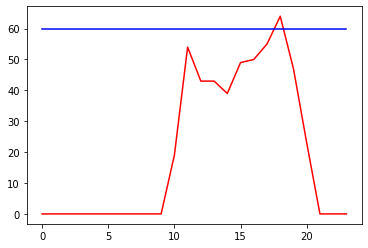

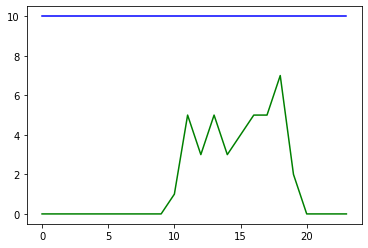

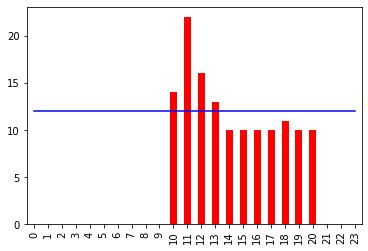

In [55]:
# test for the display fof graphs based on one selected desk
desk = ['3']
workload_dist(desk)
releases_dist(desk)
cities_dist(desk)